In [1]:
import pandas as pd
from Main import settings, features, pf_set
import time
import pickle
from pandas.tseries.offsets import DateOffset
import Prepare_Data
import data_run_files
import return_prediction_functions
from return_prediction_functions import rff
import numpy as np
from pandas.tseries.offsets import MonthEnd
from sklearn.linear_model import Ridge
import General_Functions
# exec(open("Prepare_Data.py").read()) # udkommenteret, da jeg ikke lige ved, om den bliver brugt.
# exec(open("data_run_files.py").read()) # mulighed for denne løsning
file_path_usa_dsf = "./data_fifty/usa_dsf.parquet"
file_path_usa = "./data_fifty/usa_rvol.parquet"
file_path_id_test = "./data_fifty/top_5_percent_ids.csv"
file_path_market_returns = "./data_fifty/market_returns_test.csv"
output_path_usa_dsf = "./data_fifty/usa_dsf_test.parquet"
output_path_usa = "./data_fifty/usa_test.parquet"
output_path_market_returns = "data_fifty/market_returns_test.csv"
file_path_world_ret = "./data_fifty/world_ret_test.csv"
start_date = pd.to_datetime('1952-12-31')
end_date = pd.to_datetime('2022-12-31')

output_path = "./data_fifty/"

file_path_usa_test = "./data_fifty/usa_test.parquet"
daily_file_path = "./data_fifty/usa_dsf_test.parquet"
file_path_world_ret = "./data_fifty/world_ret_test.csv" 
risk_free_path = "./data_fifty/risk_free_test.csv"   # samme
market_path = "./data_fifty/market_returns_test.csv" # samme

#rente_path = "data_fifty/ff3_m.csv"


# Kører funktioner fra data_run_files
risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date)
h_list = [1]  # Horisonter
#chars, daily = Prepare_Data.process_all_data(file_path_usa_test, daily_file_path, file_path_world_ret, risk_free_path, market_path)

Features list length: 154
Filtrering udført. Antal rækker efter filtrering: 841
Fil gemt som ./data_test/risk_free_test.csv


# Data_ret og data_ret_ld1

In [2]:
def create_data_ret_and_data_ret_ld1(file_path_world_ret, risk_free, output_data_ret_csv, output_data_ret_ld1_csv):
    # Læs og filtrer data
    df_test = pd.read_csv(file_path_world_ret)
    kolonner = ["excntry", "id", "eom", "ret_exc"]
    monthly = df_test[kolonner]
    monthly = monthly[(monthly["excntry"] == "USA") & (monthly["id"] <= 99999)]
    monthly["eom"] = pd.to_datetime(monthly["eom"])
    
    # Beregn long horizon returns (antager, at funktionen long_horizon_ret er defineret)
    data_ret = General_Functions.long_horizon_ret(data=monthly, 
                                h=settings['pf']['hps']['m1']['K'], 
                                impute="zero")
    
    # Opret data_ret_ld1 med de relevante kolonner og beregn eom_ret
    data_ret_ld1 = data_ret[['id', 'eom', 'ret_ld1']].copy()
    data_ret_ld1['eom_ret'] = data_ret_ld1['eom'] + MonthEnd(1)
    
    # Merge med risk_free og beregn total return tr_ld1
    data_ret_ld1 = data_ret_ld1.merge(risk_free, on='eom', how='left')
    data_ret_ld1['tr_ld1'] = data_ret_ld1['ret_ld1'] + data_ret_ld1['rf']
    
    # Fjern kolonnen 'rf'
    data_ret_ld1 = data_ret_ld1.drop(columns=['rf'])
    
    # Opret et shiftet DataFrame for at få tr_ld0 (total return fra næste periode)
    shifted = data_ret_ld1[['id', 'eom', 'tr_ld1']].copy()
    shifted['eom'] = shifted['eom'] + MonthEnd(1)
    shifted = shifted.rename(columns={'tr_ld1': 'tr_ld0'})
    
    # Merge det shiftede DataFrame med data_ret_ld1 på 'id' og 'eom'
    data_ret_ld1 = data_ret_ld1.merge(shifted[['id', 'eom', 'tr_ld0']], on=['id', 'eom'], how='left')
    
    # Fjern den midlertidige variable 'monthly'
    del monthly
    data_ret.to_csv(output_data_ret_csv, index=False)
    data_ret_ld1.to_csv(output_data_ret_ld1_csv, index=False)

    #return data_ret, data_ret_ld1

# Eksempel på brug:
#file_path_world_ret = "./data_fifty/world_ret_test.csv"
#risk_free_path = "./data_fifty/risk_free_test.csv
#start_date = pd.to_datetime('1952-12-31')
#risk_free = data_run_files.process_risk_free_rate(risk_free_path, start_date)
#output_data_ret_csv = "./data_fifty/data_ret.csv"  
#output_data_ret_ld1_csv = "./data_fifty/data_ret_ld1.csv
# data_ret, data_ret_ld1 = create_data_ret_and_data_ret_ld1(file_path_world_ret, risk_free, output_data_ret_csv, output_data_ret_ld1_csv)


In [3]:
#data_ret, data_ret_ld1 = create_data_ret_and_data_ret_ld1(file_path_world_ret, risk_free)
#Danner data_ret og data_ret_ld1 og gemmer dem som csv-filer
output_data_ret_csv = "./data_fifty/data_ret.csv"  
output_data_ret_ld1_csv = "./data_fifty/data_ret_ld1.csv"
create_data_ret_and_data_ret_ld1(file_path_world_ret, risk_free, output_data_ret_csv, output_data_ret_ld1_csv)

All missing excludes 0.38% of the observations


In [4]:
data_ret = pd.read_csv(output_data_ret_csv)
data_ret_ld1 = pd.read_csv(output_data_ret_ld1_csv)
data_ret['eom'] = pd.to_datetime(data_ret['eom'])
data_ret_ld1['eom'] = pd.to_datetime(data_ret_ld1['eom'])
data_ret_ld1['eom_ret'] = pd.to_datetime(data_ret_ld1['eom_ret'])

In [5]:
print(data_ret)

          id        eom   ret_ld1   ret_ld2   ret_ld3   ret_ld4   ret_ld5  \
0      10104 1986-04-30 -0.064934  0.031988 -0.369114  0.059902 -0.141147   
1      10104 1986-05-31  0.031988 -0.369114  0.059902 -0.141147  0.258949   
2      10104 1986-06-30 -0.369114  0.059902 -0.141147  0.258949  0.190520   
3      10104 1986-07-31  0.059902 -0.141147  0.258949  0.190520 -0.039651   
4      10104 1986-08-31 -0.141147  0.258949  0.190520 -0.039651  0.297054   
...      ...        ...       ...       ...       ...       ...       ...   
90698  92655 2022-07-31 -0.044328 -0.026268  0.096893 -0.016168 -0.032461   
90699  92655 2022-08-31 -0.026268  0.096893 -0.016168 -0.032461  0.000000   
90700  92655 2022-09-30  0.096893 -0.016168 -0.032461  0.000000  0.000000   
90701  92655 2022-10-31 -0.016168 -0.032461  0.000000  0.000000  0.000000   
90702  92655 2022-11-30 -0.032461  0.000000  0.000000  0.000000  0.000000   

        ret_ld6   ret_ld7   ret_ld8   ret_ld9  ret_ld10  ret_ld11  ret_ld12

In [6]:
print(data_ret_ld1)

          id        eom   ret_ld1    eom_ret    tr_ld1    tr_ld0
0      10104 1986-04-30 -0.064934 1986-05-31 -0.059734       NaN
1      10104 1986-05-31  0.031988 1986-06-30  0.036888 -0.059734
2      10104 1986-06-30 -0.369114 1986-07-31 -0.363914  0.036888
3      10104 1986-07-31  0.059902 1986-08-31  0.065102 -0.363914
4      10104 1986-08-31 -0.141147 1986-09-30 -0.136547  0.065102
...      ...        ...       ...        ...       ...       ...
90698  92655 2022-07-31 -0.044328 2022-08-31 -0.043528  0.055684
90699  92655 2022-08-31 -0.026268 2022-09-30 -0.024368 -0.043528
90700  92655 2022-09-30  0.096893 2022-10-31  0.098793 -0.024368
90701  92655 2022-10-31 -0.016168 2022-11-30 -0.013868  0.098793
90702  92655 2022-11-30 -0.032461 2022-12-31 -0.029561 -0.013868

[90703 rows x 6 columns]


In [7]:
print(data_ret_ld1.dtypes)

id                  int64
eom        datetime64[ns]
ret_ld1           float64
eom_ret    datetime64[ns]
tr_ld1            float64
tr_ld0            float64
dtype: object


## hælpefunktion:

## Skab data_ret_ld1

In [8]:
"""
world_ret = pd.read_csv(file_path_world_ret, usecols=["excntry", "id", "eom", "ret_exc"], dtype={"eom": str})
filtered_world_ret = world_ret[(world_ret["excntry"] == "USA") & (world_ret["id"] <= 99999)].copy()
filtered_world_ret["eom"] = pd.to_datetime(filtered_world_ret["eom"])
monthly = filtered_world_ret
data_ret = long_horizon_ret(filtered_world_ret, h=12, impute="zero")
data_ret_ld1 = data_ret.copy()
#data_ret_ld1['eom_ret'] = data_ret_ld1['eom'] + pd.DateOffset(months=1)
data_ret_ld1['eom_ret'] = (data_ret_ld1['eom'] + pd.DateOffset(months=1)) + MonthEnd(0)
data_ret_ld1 = data_ret_ld1[['id', 'eom', 'eom_ret', 'ret_ld1']]
data_ret_ld1 = data_ret_ld1.merge(risk_free, on='eom', how='left')
data_ret_ld1['tr_ld1'] = data_ret_ld1['ret_ld1'] + data_ret_ld1['rf']
data_ret_ld1.drop(columns=['rf'], inplace=True)
temp = data_ret_ld1[['id', 'eom', 'tr_ld1']].copy()

temp['eom'] = temp['eom'] + pd.offsets.MonthEnd(1)

temp = temp.rename(columns={'tr_ld1': 'tr_ld0'})

data_ret_ld1 = data_ret_ld1.merge(temp, on=['id', 'eom'], how='left')
"""
data_ret_ld1

,id,eom,ret_ld1,eom_ret,tr_ld1,tr_ld0
0,10104,1986-04-30,-0.064934,1986-05-31,-0.059734,NaN
1,10104,1986-05-31,0.031988,1986-06-30,0.036888,-0.059734
2,10104,1986-06-30,-0.369114,1986-07-31,-0.363914,0.036888
3,10104,1986-07-31,0.059902,1986-08-31,0.065102,-0.363914
4,10104,1986-08-31,-0.141147,1986-09-30,-0.136547,0.065102
...,...,...,...,...,...,...
90698,92655,2022-07-31,-0.044328,2022-08-31,-0.043528,0.055684
90699,92655,2022-08-31,-0.026268,2022-09-30,-0.024368,-0.043528
90700,92655,2022-09-30,0.096893,2022-10-31,0.098793,-0.024368
90701,92655,2022-10-31,-0.016168,2022-11-30,-0.013868,0.098793


In [9]:
wealth_end = pf_set["wealth"]
end = settings["split"]["test_end"]
market_test = Prepare_Data.load_and_filter_market_returns_test(output_path_market_returns)
wealth = Prepare_Data.wealth_func(wealth_end, end, market_test, risk_free)
wealth = wealth.dropna(subset=['wealth'])
print(wealth)

Filen er indlæst og filtreret succesfuldt.
           eom        wealth    mu_ld1
0   1952-11-30  1.478890e+06  0.030713
1   1952-12-31  1.525750e+06 -0.001577
2   1953-01-31  1.523347e+06 -0.001627
3   1953-02-28  1.520872e+06 -0.012860
4   1953-03-31  1.501562e+06 -0.027552
..         ...           ...       ...
837 2022-08-31  1.007982e+10 -0.091370
838 2022-09-30  9.235940e+09  0.081350
839 2022-10-31  1.005382e+10  0.051329
840 2022-11-30  1.059779e+10 -0.059779
841 2022-12-31  1.000000e+10       NaN

[842 rows x 3 columns]


## chars

In [10]:
chars = pd.read_parquet(output_path_usa)
print("Dimensioner for fulde data:")
print(chars.shape)

# ---------------------------------------------------------
# 2. Definér de kolonner, der skal hentes (unik liste)
# Her antages, at 'features' er en liste med ekstra kolonnenavne
selected_cols = list(set(["id", "eom", "sic", "size_grp", "me", "rvol_252d", "dolvol_126d"] + features))
# Læs kun de nødvendige kolonner fra Parquet-filen
chars = pd.read_parquet(output_path_usa, columns=selected_cols)

chars = chars[chars['id'] <= 99999]
chars['eom'] = pd.to_datetime(chars['eom'])

print("Dimensioner efter valg af kolonner:")

print(chars.shape)

chars['dolvol'] = chars['dolvol_126d']
# b) 'lambda' beregnes som 2/dolvol * settings['pi']
chars['lambda'] = 2 / chars['dolvol'] * settings['pi']
# c) 'rvol_m' beregnes som rvol_252d * sqrt(21)
chars['rvol_m'] = chars['rvol_252d'] * np.sqrt(21)

chars = pd.merge(chars, data_ret_ld1, on=['id', 'eom'], how='left')


temp = wealth.copy()
# Flyt eom til den sidste dag i næste måned:
temp['eom'] = temp['eom'] + pd.offsets.MonthEnd(1)
# Omdøb 'mu_ld1' til 'mu_ld0'
temp = temp.rename(columns={'mu_ld1': 'mu_ld0'})
# Merge wealth-data med chars på kolonnen eom
chars = pd.merge(chars, temp[['eom', 'mu_ld0']], on='eom', how='left')
print("Data efter merge med data_ret_ld1:")
print(chars.shape)

# Date screen: Udregn andelen af rækker, hvor eom ligger uden for screens-intervallet
date_excludes = ((chars['eom'] < settings['screens']['start']) | (chars['eom'] > settings['screens']['end'])).mean() * 100
print(f"   Date screen excludes {date_excludes:.2f}% of the observations")

# Filtrer data, så kun rækker med eom inden for intervallet beholdes
chars = chars[(chars['eom'] >= settings['screens']['start']) & (chars['eom'] <= settings['screens']['end'])]
print("Dim after date screen:", chars.shape)

# Monitor screen impact
n_start = chars.shape[0]
me_start = chars['me'].sum(skipna=True)

# Require non-missing me
me_missing_pct = chars['me'].isna().mean() * 100
print(f"   Non-missing me excludes {me_missing_pct:.2f}% of the observations")
chars = chars[~chars['me'].isna()]

# Require non-missing return for t og t+1: (tr_ld1 og tr_ld0)
valid_return_excludes = ((chars['tr_ld1'].isna()) | (chars['tr_ld0'].isna())).mean() * 100
print(f"   Valid return req excludes {valid_return_excludes:.2f}% of the observations")
chars = chars[chars['tr_ld0'].notna() & chars['tr_ld1'].notna()]

print("Final dim:", chars.shape)


Dimensioner for fulde data:
(88864, 164)
Dimensioner efter valg af kolonner:
(88864, 120)
Data efter merge med data_ret_ld1:
(88864, 128)
   Date screen excludes 17.38% of the observations
Dim after date screen: (73416, 128)
   Non-missing me excludes 0.00% of the observations
   Valid return req excludes 0.25% of the observations
Final dim: (73236, 128)


In [11]:
dolvol_excludes = ((chars['dolvol'].isna()) | (chars['dolvol'] == 0)).mean() * 100
print(f"   Non-missing/non-zero dolvol excludes {dolvol_excludes:.2f}% of the observations")

# Filtrer rækker, hvor 'dolvol' ikke er missing og > 0
chars = chars[(~chars['dolvol'].isna()) & (chars['dolvol'] > 0)]

# --- Require valid SIC code ---
# Beregn andelen af observationer med en tom SIC (""), svarende til R's mean(chars$sic=="")
sic_excludes = (chars['sic'] == "").mean() * 100
print(f"   Valid SIC code excludes {sic_excludes:.2f}% of the observations")

# Filtrer rækker, hvor 'sic' ikke er missing
chars = chars[~chars['sic'].isna()]

# --- Feature screens ---
# For hver række beregnes antallet af ikke-missing feature-værdier (for de kolonner, der er defineret i 'features')
feat_available = chars[features].notna().sum(axis=1)

# Minimum antal features, som kræves: floor(antal features * settings['screens']['feat_pct'])
min_feat = int(np.floor(len(features) * settings['screens']['feat_pct']))

# Udregn procentdelen af observationer, hvor antallet af tilgængelige features er mindre end min_feat
feat_excludes = (feat_available < min_feat).mean() * 100
print(f"   At least {settings['screens']['feat_pct']*100:.0f}% of feature excludes {feat_excludes:.2f}% of the observations")

# Filtrer rækker, hvor antallet af tilgængelige features er >= min_feat
chars = chars[feat_available >= min_feat]
print("Final dimensions after feature screen:", chars.shape)

   Non-missing/non-zero dolvol excludes 0.03% of the observations
   Valid SIC code excludes 0.05% of the observations
   At least 50% of feature excludes 0.00% of the observations
Final dimensions after feature screen: (73216, 128)


In [12]:
final_obs_pct = (len(chars) / n_start) * 100
final_me_pct = (chars['me'].sum() / me_start) * 100
print(f"   In total, the final dataset has {final_obs_pct:.2f}% of the observations and {final_me_pct:.2f}% of the market cap in the post {settings['screens']['start']} data")
run_sub = False
if run_sub:
    np.random.seed(settings['seed'])
    unique_ids = chars['id'].unique()
    sample_ids = np.random.choice(unique_ids, size=2500, replace=False)
    chars = chars[chars['id'].isin(sample_ids)]
if settings['feat_prank']:
    # Konverter feature-kolonner til float (dobbelt præcision)
    chars[features] = chars[features].astype(float)
    
    def ecdf_transform(s):
        return s.rank(method='average', pct=True)
    
    for i, f in enumerate(features):
        if (i + 1) % 10 == 0:
            print(f"Feature {i+1} out of {len(features)}")
        
        # Gem en lokal variabel med indikator for nøjagtige nuller
        zero = (chars[f] == 0)
        
        # Udfør ECDF-transformation per gruppe defineret af 'eom'
        chars[f] = chars.groupby('eom')[f].transform(lambda s: ecdf_transform(s))
        
        # Sæt de oprindelige 0-værdier tilbage til 0
        chars.loc[zero, f] = 0


   In total, the final dataset has 99.73% of the observations and 99.38% of the market cap in the post 1982-12-31 00:00:00 data
Feature 10 out of 115
Feature 20 out of 115
Feature 30 out of 115
Feature 40 out of 115
Feature 50 out of 115
Feature 60 out of 115
Feature 70 out of 115
Feature 80 out of 115
Feature 90 out of 115
Feature 100 out of 115
Feature 110 out of 115


In [13]:
if settings['feat_impute']:
    if settings['feat_prank']:
        # For hvert feature: hvis manglende, sæt til 0.5
        for f in features:
            chars[f] = chars[f].fillna(0.5)
    else:
        # For hvert feature: imputér manglende værdier med median inden for hver eom-gruppe
        for f in features:
            chars[f] = chars.groupby('eom')[f].transform(lambda s: s.fillna(s.median()))


In [14]:
# Konverter sic til numerisk (fejl konverteres til NaN)
chars['sic'] = pd.to_numeric(chars['sic'], errors='coerce')


cond_no_dur = (
    chars['sic'].between(100, 999) |
    chars['sic'].between(2000, 2399) |
    chars['sic'].between(2700, 2749) |
    chars['sic'].between(2770, 2799) |
    chars['sic'].between(3100, 3199) |
    chars['sic'].between(3940, 3989)
)

cond_durbl = (
    chars['sic'].between(2500, 2519) |
    chars['sic'].between(3630, 3659) |
    chars['sic'].isin([3710, 3711, 3714, 3716]) |
    chars['sic'].between(3750, 3751) |
    (chars['sic'] == 3792) |
    chars['sic'].between(3900, 3939) |
    chars['sic'].between(3990, 3999)
)

cond_manuf = (
    chars['sic'].between(2520, 2589) |
    chars['sic'].between(2600, 2699) |
    chars['sic'].between(2750, 2769) |
    chars['sic'].between(3000, 3099) |
    chars['sic'].between(3200, 3569) |
    chars['sic'].between(3580, 3629) |
    chars['sic'].between(3700, 3709) |
    chars['sic'].between(3712, 3713) |
    (chars['sic'] == 3715) |
    chars['sic'].between(3717, 3749) |
    chars['sic'].between(3752, 3791) |
    chars['sic'].between(3793, 3799) |
    chars['sic'].between(3830, 3839) |
    chars['sic'].between(3860, 3899)
)

cond_enrgy = (
    chars['sic'].between(1200, 1399) |
    chars['sic'].between(2900, 2999)
)

cond_chems = (
    chars['sic'].between(2800, 2829) |
    chars['sic'].between(2840, 2899)
)

cond_buseq = (
    chars['sic'].between(3570, 3579) |
    chars['sic'].between(3660, 3692) |
    chars['sic'].between(3694, 3699) |
    chars['sic'].between(3810, 3829) |
    chars['sic'].between(7370, 7379)
)

cond_telcm = chars['sic'].between(4800, 4899)
cond_utils = chars['sic'].between(4900, 4949)

cond_shops = (
    chars['sic'].between(5000, 5999) |
    chars['sic'].between(7200, 7299) |
    chars['sic'].between(7600, 7699)
)

cond_hlth = (
    chars['sic'].between(2830, 2839) |
    (chars['sic'] == 3693) |
    chars['sic'].between(3840, 3859) |
    chars['sic'].between(8000, 8099)
)

cond_money = chars['sic'].between(6000, 6999)

# Saml betingelser og tilhørende valg
conditions = [
    cond_no_dur,
    cond_durbl,
    cond_manuf,
    cond_enrgy,
    cond_chems,
    cond_buseq,
    cond_telcm,
    cond_utils,
    cond_shops,
    cond_hlth,
    cond_money
]

choices = [
    "NoDur",
    "Durbl",
    "Manuf",
    "Enrgy",
    "Chems",
    "BusEq",
    "Telcm",
    "Utils",
    "Shops",
    "Hlth",
    "Money"
]

# Opret kolonnen ff12 med værdien "Other", hvis ingen betingelser er opfyldte
chars['ff12'] = np.select(conditions, choices, default="Other")

C:\Users\andre\AppData\Local\Temp\ipykernel_16704\1530898857.py:107: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  chars['ff12'] = np.select(conditions, choices, default="Other")


In [15]:
chars.head

<bound method NDFrame.head of         bev_mev  taccruals_at  prc_highprc_252d   cash_at  rmax1_21d  \
0      0.075269      0.972603          0.145833  0.708333   0.978947   
1      0.063830      0.972603          0.385417  0.729167   0.968750   
2      0.042553      0.958904          0.963542  0.729167   0.937500   
3      0.052632      1.000000          0.927835  0.484536   0.845361   
4      0.042553      1.000000          0.536082  0.484536   0.968750   
...         ...           ...               ...       ...        ...   
88847  0.245614      0.547486          0.966667  0.633333   0.772222   
88848  0.251462      0.541899          0.922222  0.633333   0.188889   
88849  0.216374      0.536313          0.966667  0.633333   0.355556   
88850  0.239766      0.519553          0.983333  0.627778   0.016667   
88851  0.284884      0.497207          0.883333  0.633333   0.294444   

       tax_gr1a  iskew_capm_21d  oaccruals_ni  ami_126d     at_me  ...  \
0      0.947917        0.978947

In [16]:
# Først: sortér DataFrame (ingen indsættelser sker her)
chars.sort_values(['id', 'eom'], inplace=True)

# Beregn lb
lb = pf_set['lb_hor'] + 1

# Beregn eom_lag og month_diff som separate serier
eom_lag_series = chars.groupby('id')['eom'].shift(lb)

def calc_month_diff(row):
    # Hvis eom_lag er NaT, returner NaN
    if pd.isna(row['eom_lag']):
        return np.nan
    return (row['eom'].year - row['eom_lag'].year) * 12 + (row['eom'].month - row['eom_lag'].month)

# Lav en midlertidig DataFrame for beregninger (uden at ændre chars løbende)
temp_df = pd.concat([chars['eom'], eom_lag_series.rename('eom_lag')], axis=1)
temp_df['month_diff'] = temp_df.apply(lambda row: calc_month_diff(row), axis=1)

# Udregn exclusion rate (for de rækker hvor valid_data oprindeligt er True)
# Her antages alle observationer at være gyldige til at starte med
exclusion_rate = (((temp_df['month_diff'] != lb) | (temp_df['month_diff'].isna())).mean()) * 100
print(f"   Valid lookback observation screen excludes {exclusion_rate:.2f}% of the observations")

# Opdater valid_data: kun rækker med month_diff lig lb og ikke NaN er gyldige
valid_data_series = (temp_df['month_diff'] == lb) & (~temp_df['month_diff'].isna())

# Tilføj valid_data til chars ved at bruge pd.concat (samler alle nye kolonner på én gang)
new_cols = pd.DataFrame({
    'valid_data': valid_data_series,
    'eom_lag': temp_df['eom_lag'],
    'month_diff': temp_df['month_diff']
}, index=chars.index)

chars = pd.concat([chars, new_cols], axis=1)

# Opdater valid_data-kolonnen i chars
chars['valid_data'] = chars['valid_data']

# Fjern de midlertidige kolonner
chars.drop(columns=['eom_lag', 'month_diff'], inplace=True)


   Valid lookback observation screen excludes 3.41% of the observations


In [17]:
chars

,bev_mev,taccruals_at,prc_highprc_252d,cash_at,rmax1_21d,tax_gr1a,iskew_capm_21d,oaccruals_ni,ami_126d,at_me,...,dolvol,lambda,rvol_m,ret_ld1,eom_ret,tr_ld1,tr_ld0,mu_ld0,ff12,valid_data
0,0.075269,0.972603,0.145833,0.708333,0.978947,0.947917,0.978947,0.849315,0.937500,0.041667,...,5.952293e+05,3.360050e-07,0.165542,0.297054,1987-01-31,0.301954,-0.035751,-0.026385,BusEq,False
1,0.063830,0.972603,0.385417,0.729167,0.968750,0.937500,0.864583,0.780822,0.937500,0.041667,...,9.014952e+05,2.218537e-07,0.170561,0.421617,1987-02-28,0.425817,0.301954,0.129587,BusEq,False
2,0.042553,0.958904,0.963542,0.729167,0.937500,0.937500,0.791667,0.753425,0.937500,0.031250,...,1.271623e+06,1.572793e-07,0.170986,0.137845,1987-03-31,0.142145,0.425817,0.048378,BusEq,False
3,0.052632,1.000000,0.927835,0.484536,0.845361,0.927835,0.453608,0.837838,0.907216,0.030928,...,1.463353e+06,1.366724e-07,0.173280,0.063897,1987-04-30,0.068597,0.142145,0.023201,BusEq,False
4,0.042553,1.000000,0.536082,0.484536,0.968750,0.917526,0.166667,0.861111,0.917526,0.020619,...,1.892803e+06,1.056634e-07,0.174032,0.155814,1987-05-31,0.160214,0.068597,-0.016540,BusEq,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88847,0.245614,0.547486,0.966667,0.633333,0.772222,0.177778,0.666667,0.642458,0.061111,0.233333,...,1.633418e+09,1.224426e-10,0.069191,-0.044328,2022-08-31,-0.043528,0.055684,0.093630,Money,True
88848,0.251462,0.541899,0.922222,0.633333,0.188889,0.194444,0.294444,0.625698,0.033333,0.233333,...,1.558158e+09,1.283567e-10,0.068704,-0.026268,2022-09-30,-0.024368,-0.043528,-0.036188,Money,True
88849,0.216374,0.536313,0.966667,0.633333,0.355556,0.200000,0.916667,0.631285,0.033333,0.227778,...,1.516174e+09,1.319110e-10,0.068843,0.096893,2022-10-31,0.098793,-0.024368,-0.091370,Money,True
88850,0.239766,0.519553,0.983333,0.627778,0.016667,0.577778,0.411111,0.659218,0.033333,0.238889,...,1.494588e+09,1.338161e-10,0.068225,-0.016168,2022-11-30,-0.013868,0.098793,0.081350,Money,True


In [18]:
## Hjælpefunktioner

In [19]:
def investment_universe(add, delete):
    """
    Beregner en logisk vektor, der angiver om et aktiv (i en tidsserie)
    skal inkluderes i investeringsuniverset.
    
    Parametre:
      add (list eller 1D-array af bool): Tilføjningsflag pr. periode.
      delete (list eller 1D-array af bool): Sletningsflag pr. periode.
      
    Returnerer:
      included (list af bool): Resultat for hver periode.
    """
    n = len(add)
    included = [False] * n
    state = False
    # Start fra anden observation (python-indeks 1)
    for i in range(1, n):
        # Inkludér hvis aktivet ikke er inkluderet,
        # men får et tilføjningssignal nu (og ikke fik signal i forrige periode)
        if (not state) and add[i] and (not add[i-1]):
            state = True
        # Fjern aktivet hvis det er inkluderet og får sletningssignal
        if state and delete[i]:
            state = False
        included[i] = state
    return included


In [20]:
import re

def size_screen_fun(chars, type_screen):
    """
    Size-based screen function. Modifies DataFrame 'chars' in place.
    
    Parametre:
      chars (pd.DataFrame): DataFrame med mindst kolonnerne 'valid_data', 'me',
                            og evt. 'size_grp'.
      type_screen (str): Angiver, hvilken type screen der skal anvendes. Skal være
                         præcis én af:
                           - "all"
                           - "topN" (f.eks. "top1000")
                           - "bottomN" (f.eks. "bottom100")
                           - "size_grp_{gruppe}" (f.eks. "size_grp_small")
                           - En procent-baseret string indeholdende "perc", "low", "high" og "min"
                             f.eks. "perc_low20high80min50"
    
    Funktionen tjekker, at præcis én screen-type er anvendt. Hvis ikke, kastes en fejl.
    """
    count = 0
    # --- Screen: All ---
    if type_screen == "all":
        print("No size screen")
        chars.loc[chars['valid_data'] == True, 'valid_size'] = True
        count += 1

    # --- Screen: Top N ---
    if "top" in type_screen:
        # Ekstraher tallet fra strengen (fjerner alle ikke-cifrede tegn)
        top_n = int(re.sub(r"\D", "", type_screen))
        # For rækker hvor valid_data er True, beregn rangeringen af me (descending) inden for hver eom
        chars.loc[chars['valid_data'] == True, 'me_rank'] = chars.groupby('eom')['me'].rank(ascending=False, method='first')
        # Sæt valid_size til True, hvis me_rank <= top_n og me_rank ikke er NA
        chars['valid_size'] = (chars['me_rank'] <= top_n) & (~chars['me_rank'].isna())
        # Fjern den midlertidige kolonne
        chars.drop(columns='me_rank', inplace=True)
        count += 1

    # --- Screen: Bottom N ---
    if "bottom" in type_screen:
        bot_n = int(re.sub(r"\D", "", type_screen))
        chars.loc[chars['valid_data'] == True, 'me_rank'] = chars.groupby('eom')['me'].rank(ascending=True, method='first')
        chars['valid_size'] = (chars['me_rank'] <= bot_n) & (~chars['me_rank'].isna())
        chars.drop(columns='me_rank', inplace=True)
        count += 1

    # --- Screen: Size group ---
    if "size_grp_" in type_screen:
        size_grp_screen = type_screen.replace("size_grp_", "")
        chars['valid_size'] = (chars['size_grp'] == size_grp_screen) & (chars['valid_data'] == True)
        count += 1

    # --- Screen: Percentile-based ---
    if "perc" in type_screen:
        low_match = re.search(r"(?<=low)\d+", type_screen)
        high_match = re.search(r"(?<=high)\d+", type_screen)
        min_match = re.search(r"(?<=min)\d+", type_screen)
        if low_match and high_match and min_match:
            low_p = int(low_match.group())
            high_p = int(high_match.group())
            min_n = int(min_match.group())
        else:
            raise ValueError("Percentile screen format invalid.")
        print(f"Percentile-based screening: Range {low_p}% - {high_p}%, min_n: {min_n} stocks")
        # For rækker hvor valid_data er True: beregn ECDF for me inden for hver eom (brug rank i procent)
        chars.loc[chars['valid_data'] == True, 'me_perc'] = chars.groupby('eom')['me'].transform(lambda s: s.rank(method='average', pct=True))
        # Sæt valid_size til True, hvis me_perc ligger inden for (low_p/100, high_p/100]
        chars['valid_size'] = (chars['me_perc'] > (low_p / 100)) & (chars['me_perc'] <= (high_p / 100)) & (~chars['me_perc'].isna())
        # Beregn gruppe-specifik statistik for hver eom
        group_stats = chars.groupby('eom').apply(lambda g: pd.Series({
            'n_tot': g['valid_data'].sum(),
            'n_size': g['valid_size'].sum(),
            'n_less': ((g['valid_data'] == True) & (g['me_perc'] <= (low_p / 100))).sum(),
            'n_more': ((g['valid_data'] == True) & (g['me_perc'] > (high_p / 100))).sum()
        }))
        # Merge disse stats tilbage til chars
        chars = chars.merge(group_stats, left_on='eom', right_index=True, how='left')
        # Beregn antallet af manglende aktier, der skal tilføjes
        chars['n_miss'] = np.maximum(min_n - chars['n_size'], 0)
        # Beregn hvor mange aktier der skal tilføjes fra neden og ovenfra
        chars['n_below'] = np.ceil(np.minimum(chars['n_miss'] / 2, chars['n_less']))
        chars['n_above'] = np.ceil(np.minimum(chars['n_miss'] / 2, chars['n_more']))
        # Juster, hvis summen af n_below og n_above er mindre end n_miss
        cond = (chars['n_below'] + chars['n_above'] < chars['n_miss']) & (chars['n_above'] > chars['n_below'])
        chars.loc[cond, 'n_above'] = chars.loc[cond, 'n_above'] + (chars.loc[cond, 'n_miss'] - chars.loc[cond, 'n_above'] - chars.loc[cond, 'n_below'])
        cond = (chars['n_below'] + chars['n_above'] < chars['n_miss']) & (chars['n_above'] < chars['n_below'])
        chars.loc[cond, 'n_below'] = chars.loc[cond, 'n_below'] + (chars.loc[cond, 'n_miss'] - chars.loc[cond, 'n_above'] - chars.loc[cond, 'n_below'])
        # Endelig: sæt valid_size, med en udvidet grænse baseret på de beregnede tilføjelser
        chars['valid_size'] = (chars['me_perc'] > (low_p/100 - chars['n_below']/chars['n_tot'])) & \
                              (chars['me_perc'] <= (high_p/100 + chars['n_above']/chars['n_tot'])) & \
                              (~chars['me_perc'].isna())
        # Fjern de midlertidige kolonner
        for col in ['me_perc', 'n_tot', 'n_size', 'n_less', 'n_more', 'n_miss', 'n_below', 'n_above']:
            if col in chars.columns:
                chars.drop(columns=col, inplace=True)
        count += 1

    if count != 1:
        raise ValueError("Invalid size screen applied!!!!")
    
    return chars


In [21]:
def addition_deletion_fun(chars, addition_n, deletion_n, pf_set):
    """
    Anvender addition/deletion-reglen på DataFrame 'chars'.
    
    Parametre:
      chars (pd.DataFrame): Datasættet med aktieobservationer.
      addition_n (int): Vindueslængde for addition (rullende sum).
      deletion_n (int): Vindueslængde for deletion (rullende sum).
      pf_set (dict): Indstillinger; herunder forventes pf_set['lb_hor'] at være defineret.
      
    Funktionen:
      - Opretter en midlertidig kolonne 'valid_temp' (valid_data AND valid_size)
      - Sorterer data efter id og eom.
      - Beregner rullende summer for valid_temp over vinduerne addition_n og deletion_n.
      - Definerer flagget 'add' (når addition_count == addition_n) og 'delete' (når deletion_count == 0).
      - For hver aktie (id) med mere end én observation, anvendes investment_universe til at udlede en kolonne 'valid'.
      - For aktier med kun én observation sættes valid til False.
      - Hvis valid_data er False, sættes valid til False.
      - Beregner turnover (ændring) både for den rå validitet (valid_temp) og den justerede validitet (valid).
      - Udregner og printer gennemsnitlig turnover pr. eom.
      - Fjerner de midlertidige kolonner.
    """
    # 1. Opret valid_temp
    chars['valid_temp'] = (chars['valid_data'] == True) & (chars['valid_size'] == True)
    
    # 2. Sortér efter id og eom
    chars.sort_values(['id', 'eom'], inplace=True)
    
    # 3. Beregn rullende summer for valid_temp inden for hver id
    chars['valid_int'] = chars['valid_temp'].astype(int)
    chars['addition_count'] = chars.groupby('id')['valid_int']\
                                    .transform(lambda s: s.rolling(window=addition_n, min_periods=addition_n).sum())
    chars['deletion_count'] = chars.groupby('id')['valid_int']\
                                    .transform(lambda s: s.rolling(window=deletion_n, min_periods=deletion_n).sum())
    
    # 4. Definer flag for addition og deletion
    chars['add'] = (chars['addition_count'] == addition_n)
    chars['add'] = chars['add'].fillna(False)
    chars['delete'] = (chars['deletion_count'] == 0)
    chars['delete'] = chars['delete'].fillna(False)
    
    # 5. Beregn antallet af observationer per id
    chars['n'] = chars.groupby('id')['id'].transform('count')
    
    # 6. Anvend investment_universe for at udlede 'valid'
    def apply_investment_universe(df):
        add_list = df['add'].tolist()
        delete_list = df['delete'].tolist()
        valid_list = investment_universe(add_list, delete_list)
        return pd.Series(valid_list, index=df.index)
    
    chars.loc[chars['n'] > 1, 'valid'] = chars.groupby('id').apply(
        lambda g: apply_investment_universe(g) if len(g) > 1 else False
    ).reset_index(level=0, drop=True)
    
    chars.loc[chars['n'] == 1, 'valid'] = False
    chars.loc[chars['valid_data'] == False, 'valid'] = False
    
    # 7. Beregn Turnover
    chars['chg_raw'] = chars.groupby('id')['valid_temp'].transform(lambda s: s != s.shift(1))
    chars['chg_adj'] = chars.groupby('id')['valid'].transform(lambda s: s != s.shift(1))
    
    chars['valid_temp_int'] = chars['valid_temp'].astype(int)
    chars['valid_int_new'] = chars['valid'].astype(int)
    chars['chg_raw_int'] = chars['chg_raw'].astype(int)
    chars['chg_adj_int'] = chars['chg_adj'].astype(int)
    
    # Aggreger pr. eom
    turnover = chars.groupby('eom').agg(
        raw_n = pd.NamedAgg(column='valid_temp_int', aggfunc='sum'),
        adj_n = pd.NamedAgg(column='valid_int_new', aggfunc='sum'),
        raw = pd.NamedAgg(column='chg_raw_int', aggfunc='sum'),
        total_valid_temp = pd.NamedAgg(column='valid_temp_int', aggfunc='sum'),
        total_valid = pd.NamedAgg(column='valid_int_new', aggfunc='sum'),
        adj_sum = pd.NamedAgg(column='chg_adj_int', aggfunc='sum')
    ).reset_index()
    
    turnover['raw'] = turnover.apply(lambda row: row['raw'] / row['total_valid_temp'] if row['total_valid_temp'] > 0 else np.nan, axis=1)
    turnover['adj'] = turnover.apply(lambda row: row['adj_sum'] / row['total_valid'] if row['total_valid'] > 0 else np.nan, axis=1)
    
    valid_turnover = turnover[(~turnover['raw'].isna()) & (~turnover['adj'].isna()) & (turnover['adj'] != 0)]
    
    # Her beregner vi gennemsnittet af turnover over alle eom
    mean_raw = valid_turnover['raw'].mean()
    mean_adj = valid_turnover['adj'].mean()
    
    print(f"Turnover wo addition/deletion rule: {mean_raw*100:.2f}%")
    print(f"Turnover w  addition/deletion rule: {mean_adj*100:.2f}%")
    
    # 8. Fjern midlertidige kolonner
    cols_to_drop = ['n', 'addition_count', 'deletion_count', 'add', 'delete', 
                    'valid_temp', 'valid_data', 'valid_size', 
                    'chg_raw', 'chg_adj', 'valid_temp_int', 'valid_int_new',
                    'chg_raw_int', 'chg_adj_int']
    chars.drop(columns=cols_to_drop, inplace=True)
    
    return chars


In [22]:
type_screen = "all"
chars = size_screen_fun(chars, type_screen)
#print(chars)
print(chars.shape)

No size screen
(73216, 131)


In [23]:
chars = addition_deletion_fun(chars, addition_n=settings['addition_n'], deletion_n=settings['deletion_n'], pf_set=settings)
print(chars)
print(chars.shape)

Turnover wo addition/deletion rule: 1.09%
Turnover w  addition/deletion rule: 2.33%
        bev_mev  taccruals_at  prc_highprc_252d   cash_at  rmax1_21d  \
0      0.075269      0.972603          0.145833  0.708333   0.978947   
1      0.063830      0.972603          0.385417  0.729167   0.968750   
2      0.042553      0.958904          0.963542  0.729167   0.937500   
3      0.052632      1.000000          0.927835  0.484536   0.845361   
4      0.042553      1.000000          0.536082  0.484536   0.968750   
...         ...           ...               ...       ...        ...   
88847  0.245614      0.547486          0.966667  0.633333   0.772222   
88848  0.251462      0.541899          0.922222  0.633333   0.188889   
88849  0.216374      0.536313          0.966667  0.633333   0.355556   
88850  0.239766      0.519553          0.983333  0.627778   0.016667   
88851  0.284884      0.497207          0.883333  0.633333   0.294444   

       tax_gr1a  iskew_capm_21d  oaccruals_ni  ami_

C:\Users\andre\AppData\Local\Temp\ipykernel_16704\4257758924.py:52: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  chars.loc[chars['n'] > 1, 'valid'] = chars.groupby('id').apply(


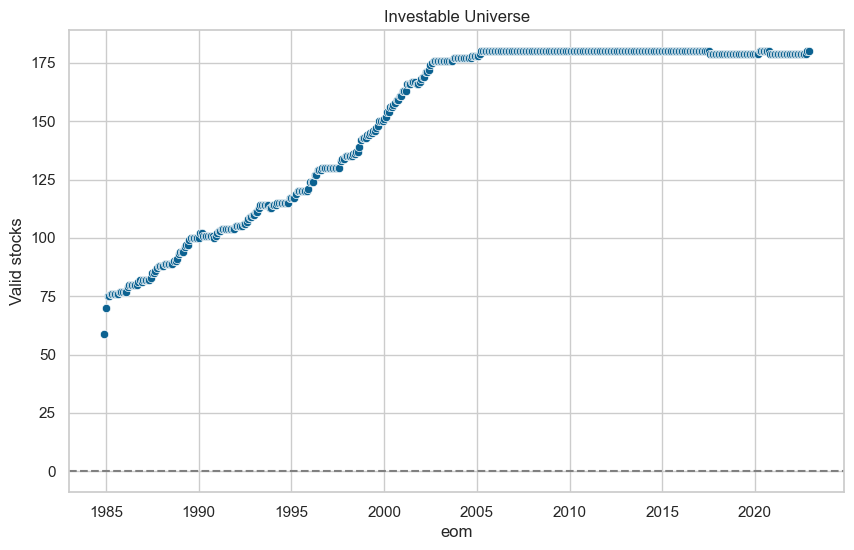

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns


valid_counts = chars.loc[chars['valid'] == True].groupby('eom').size().reset_index(name='N')

# Plot investable universe
plt.figure(figsize=(10,6))
sns.scatterplot(data=valid_counts, x='eom', y='N')
plt.ylabel("Valid stocks")
plt.axhline(y=0, color='gray', linestyle='--')
plt.title("Investable Universe")
plt.show()

In [25]:
valid_pct = (chars['valid'].mean() * 100)
market_cap_valid = (chars.loc[chars['valid'] == True, 'me'].sum() / chars['me'].sum()) * 100
print(f"   The valid_data subset has {valid_pct:.2f}% of the observations and {market_cap_valid:.2f}% of the market cap")

   The valid_data subset has 93.70% of the observations and 99.44% of the market cap


In [26]:
chars

,bev_mev,taccruals_at,prc_highprc_252d,cash_at,rmax1_21d,tax_gr1a,iskew_capm_21d,oaccruals_ni,ami_126d,at_me,...,lambda,rvol_m,ret_ld1,eom_ret,tr_ld1,tr_ld0,mu_ld0,ff12,valid_int,valid
0,0.075269,0.972603,0.145833,0.708333,0.978947,0.947917,0.978947,0.849315,0.937500,0.041667,...,3.360050e-07,0.165542,0.297054,1987-01-31,0.301954,-0.035751,-0.026385,BusEq,0,False
1,0.063830,0.972603,0.385417,0.729167,0.968750,0.937500,0.864583,0.780822,0.937500,0.041667,...,2.218537e-07,0.170561,0.421617,1987-02-28,0.425817,0.301954,0.129587,BusEq,0,False
2,0.042553,0.958904,0.963542,0.729167,0.937500,0.937500,0.791667,0.753425,0.937500,0.031250,...,1.572793e-07,0.170986,0.137845,1987-03-31,0.142145,0.425817,0.048378,BusEq,0,False
3,0.052632,1.000000,0.927835,0.484536,0.845361,0.927835,0.453608,0.837838,0.907216,0.030928,...,1.366724e-07,0.173280,0.063897,1987-04-30,0.068597,0.142145,0.023201,BusEq,0,False
4,0.042553,1.000000,0.536082,0.484536,0.968750,0.917526,0.166667,0.861111,0.917526,0.020619,...,1.056634e-07,0.174032,0.155814,1987-05-31,0.160214,0.068597,-0.016540,BusEq,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88847,0.245614,0.547486,0.966667,0.633333,0.772222,0.177778,0.666667,0.642458,0.061111,0.233333,...,1.224426e-10,0.069191,-0.044328,2022-08-31,-0.043528,0.055684,0.093630,Money,1,True
88848,0.251462,0.541899,0.922222,0.633333,0.188889,0.194444,0.294444,0.625698,0.033333,0.233333,...,1.283567e-10,0.068704,-0.026268,2022-09-30,-0.024368,-0.043528,-0.036188,Money,1,True
88849,0.216374,0.536313,0.966667,0.633333,0.355556,0.200000,0.916667,0.631285,0.033333,0.227778,...,1.319110e-10,0.068843,0.096893,2022-10-31,0.098793,-0.024368,-0.091370,Money,1,True
88850,0.239766,0.519553,0.983333,0.627778,0.016667,0.577778,0.411111,0.659218,0.033333,0.238889,...,1.338161e-10,0.068225,-0.016168,2022-11-30,-0.013868,0.098793,0.081350,Money,1,True


In [27]:
chars.drop(columns="valid_int", inplace=True)
chars.to_parquet("./data_fifty/chars_behandlet.parquet", index=False)

In [23]:
df_usa = pd.read_parquet("./data_fifty/usa_test.parquet", engine='pyarrow')

In [24]:
df_usa.head()

,eom_ret,id,eom,valid_ret,excntry,me,sic,size_grp,ret_exc_lead1m,niq_su,...,ocf_at,ocf_at_chg1,mispricing_perf,mispricing_mgmt,qmj,qmj_prof,qmj_growth,qmj_safety,ctff_test,rvol_252d
0,1987-01-31,10104,1986-12-31,True,USA,277.19925,7370,small,0.297054,NaN,...,0.152201,-0.339631,0.518340,0.046991,NaN,0.658536,NaN,1.056774,False,0.036124
1,1987-02-28,10104,1987-01-31,True,USA,360.69300,7370,small,0.421617,NaN,...,0.152201,-0.339631,0.526047,0.047355,NaN,0.664785,NaN,1.093742,False,0.037220
2,1987-03-31,10104,1987-02-28,True,USA,514.32150,7370,large,0.137845,NaN,...,0.152201,-0.339631,0.585345,0.048170,NaN,0.679204,NaN,1.096833,False,0.037312
3,1987-04-30,10104,1987-03-31,True,USA,587.79600,7370,large,0.063897,NaN,...,-0.274303,-0.339631,0.776772,0.163565,NaN,-0.296627,NaN,1.002525,False,0.037813
4,1987-05-31,10104,1987-04-30,True,USA,627.87300,7370,large,0.155814,NaN,...,-0.274303,-0.339631,0.773349,0.169066,NaN,-0.305572,NaN,1.070931,False,0.037977


In [25]:
df_usa = pd.read_parquet("./data_fifty/usa_test.parquet", engine='pyarrow')
kolonner = ["excntry", "id", "eom", "ret_exc_lead1m"]
monthly = df_usa[kolonner]

# Omdøb kolonnen 'ret_exc_lead1m' til 'ret_exc'
monthly = monthly.rename(columns={"ret_exc_lead1m": "ret_exc"})

# Filtrer kun USA og id <= 99999
monthly = monthly[(monthly["excntry"] == "USA") & (monthly["id"] <= 99999)]

# Konverter 'eom' til datoformat
monthly["eom"] = pd.to_datetime(monthly["eom"], format="%Y%m%d")

# Initialiser en tom liste til resultater
results = []

# Loop over horisonter i h_list
for h in h_list:
    # Beregn langsigtede afkast
    data_ret = long_horizon_ret(data=monthly, h=h, impute="zero")

    # Tilføj 'eom_ret'
    #data_ret["eom_ret"] = data_ret["eom"] + MonthEnd(1)
    data_ret["eom_ret"] = (data_ret["eom"] + pd.DateOffset(months=1)) + MonthEnd(0)
    
    # Filtrer til relevante kolonner
    data_ret_ld1 = data_ret[["id", "eom", "eom_ret", f"ret_ld{h}"]]

    # Merge med risikofri data
    data_ret_ld1 = data_ret_ld1.merge(risk_free, on="eom", how="left")

    # Beregn total return
    data_ret_ld1["tr_ld1"] = data_ret_ld1[f"ret_ld{h}"] + data_ret_ld1["rf"]
    data_ret_ld1.drop(columns=["rf"], inplace=True)

    # Tilføj horisont som kolonne
    data_ret_ld1["horizon"] = h

    # Gem resultatet for denne horisont
    results.append(data_ret_ld1)

# Kombiner alle resultater til én samlet DataFrame
final_result = pd.concat(results, ignore_index=True)
final_result.to_csv("data_test/monthly_preprocessed_test.csv", index=False)

final_result

All missing excludes 1.17% of the observations


,id,eom,eom_ret,ret_ld1,tr_ld1,horizon
0,10104,1986-12-31,1987-01-31,0.421617,0.426517,1
1,10104,1987-01-31,1987-02-28,0.137845,0.142045,1
2,10104,1987-02-28,1987-03-31,0.063897,0.068197,1
3,10104,1987-03-31,1987-04-30,0.155814,0.160514,1
4,10104,1987-04-30,1987-05-31,-0.188517,-0.184117,1
...,...,...,...,...,...,...
88679,92655,2023-06-30,2023-07-31,-0.063368,NaN,1
88680,92655,2023-07-31,2023-08-31,0.057611,NaN,1
88681,92655,2023-08-31,2023-09-30,0.057504,NaN,1
88682,92655,2023-09-30,2023-10-31,0.028084,NaN,1


In [30]:
print(final_result)

          id        eom    eom_ret   ret_ld1    tr_ld1  horizon
0      10104 1986-12-31 1987-01-31  0.421617  0.426517        1
1      10104 1987-01-31 1987-02-28  0.137845  0.142045        1
2      10104 1987-02-28 1987-03-31  0.063897  0.068197        1
3      10104 1987-03-31 1987-04-30  0.155814  0.160514        1
4      10104 1987-04-30 1987-05-31 -0.188517 -0.184117        1
...      ...        ...        ...       ...       ...      ...
88679  92655 2023-06-30 2023-07-31 -0.063368       NaN        1
88680  92655 2023-07-31 2023-08-31  0.057611       NaN        1
88681  92655 2023-08-31 2023-09-30  0.057504       NaN        1
88682  92655 2023-09-30 2023-10-31  0.028084       NaN        1
88683  92655 2023-10-31 2023-11-30 -0.048789       NaN        1

[88684 rows x 6 columns]


In [28]:
print(data_ret)

          id        eom   ret_ld1    eom_ret
0      10104 1986-12-31  0.421617 1987-01-31
1      10104 1987-01-31  0.137845 1987-02-28
2      10104 1987-02-28  0.063897 1987-03-31
3      10104 1987-03-31  0.155814 1987-04-30
4      10104 1987-04-30 -0.188517 1987-05-31
...      ...        ...       ...        ...
88679  92655 2023-06-30 -0.063368 2023-07-31
88680  92655 2023-07-31  0.057611 2023-08-31
88681  92655 2023-08-31  0.057504 2023-09-30
88682  92655 2023-09-30  0.028084 2023-10-31
88683  92655 2023-10-31 -0.048789 2023-11-30

[88684 rows x 4 columns]


In [80]:
search_grid_single = pd.DataFrame({
    'name': ['m1'],
    'horizon': [1]
})
search_grid = search_grid_single

In [82]:

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen:
    h = search_grid.iloc[i]["horizon"]  # fx 1
    col_name = "ret_ld" + str(h)
    pred_y_values = data_ret[col_name]  # antages at være en Pandas Series
    pred_y_df = data_ret[['id', 'eom']].copy()

    # Beregn eom_pred_last med samme logik som i R:
    # I R beregnes: eom + 1 dag + months(max(h)) - 1 dag, hvilket forudsat at eom er en måneds-slutdato
    # svarer til at lægge h måneder til eom.
    #pred_y_df['eom_pred_last'] = pred_y_df['eom'] + pd.DateOffset(months=h)
    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + MonthEnd(h)
    valid_chars = chars[chars['valid'] == True]

    # Valgfrit: Sikr at eom_pred_last ikke overstiger den maksimalt tilgængelige dato (fra fx valid_chars)
    max_valid_eom = valid_chars['eom'].max()  # valid_chars fx: chars[chars['valid'] == True]
    pred_y_df['eom_pred_last'] = pred_y_df['eom_pred_last'].apply(lambda x: min(x, max_valid_eom))

    pred_y_df['ret_pred'] = pred_y_values

    # Join med de rækker i 'chars', hvor valid er True, på kolonnerne id og eom
   
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')

    print("data_pred.head")
    print(data_pred.head())
    print("data_pred.tail")
    print(data_pred.tail())
    print("horizons:", [h])

    # Bestem validerings-slutdatoer og test-inc baseret på settings
    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        # Opret en liste af datoer med årligt interval
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")

    op = {}  # Dictionary til at gemme modeloutput for hver val_end
    inner_start = time.time()
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
        print(val_end)
        train_test_val = return_prediction_functions.data_split(
            data_pred,
            type=update_freq,
            val_end=val_end,
            val_years=settings['split']['val_years'],
            train_start=settings['screens']['start'],
            train_lookback=settings['split']['train_lookback'],
            retrain_lookback=settings['split']['retrain_lookback'],
            test_inc=test_inc,
            test_end=settings['split']['test_end']
        )
        print("Train data:")
        print(train_test_val["train"].head())
        print("\nValidation data:")
        print(train_test_val["val"].head())
        print("\nTrain full data:")
        print(train_test_val["train_full"].head())
        print("\nTest data:")
        print(train_test_val["test"].head())
        model_start = time.time()
        model_op = return_prediction_functions.rff_hp_search(
            train_test_val,
            feat=features,
            p_vec=settings['rff']['p_vec'],
            g_vec=settings['rff']['g_vec'],
            l_vec=settings['rff']['l_vec'],
            seed=settings['seed_no']
        )
        model_time = time.time() - model_start
        print("Model training time:", model_time, "seconds")
        op[val_end] = model_op
    inner_time = time.time() - inner_start
    print("Total time for current horizon:", inner_time, "seconds")

    # Gem model-output for den aktuelle horizon til en pickle-fil (svarer til R's saveRDS)
    model_filename = f"{output_path}/model_{h}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(op, f)

    models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")

data_pred.head
      id        eom eom_pred_last  ret_pred  seas_2_5na  oaccruals_ni  \
0  10104 1988-11-30    1988-12-31  0.205772         0.5      0.637500   
1  10104 1988-12-31    1989-01-31 -0.053729         0.5      0.721519   
2  10104 1989-01-31    1989-02-28  0.066009         0.5      0.719512   
3  10104 1989-02-28    1989-03-31  0.195263         0.5      0.698795   
4  10104 1989-03-31    1989-04-30  0.043718         0.5      0.807229   

   ivol_capm_21d  ncoa_gr1a       age  lnoa_gr1a  ...        lambda    rvol_m  \
0       0.911765   0.714286  0.038835        0.5  ...  4.903319e-08  0.147527   
1       0.950495   0.789474  0.048544        0.5  ...  4.588217e-08  0.138658   
2       0.844660   0.740260  0.048077        0.5  ...  4.065264e-08  0.129306   
3       0.904762   0.756410  0.047619        0.5  ...  3.655911e-08  0.126996   
4       0.951456   0.884615  0.047619        0.5  ...  3.176299e-08  0.128771   

     eom_ret   ret_ld1    tr_ld1    tr_ld0    mu_ld0   ff12

ValueError: Found array with 0 sample(s) (shape=(0, 64)) while a minimum of 1 is required by Ridge.

In [85]:
settings['split']['train_end']
settings['split']['test_end']
#settings['split']['model_update_freq']

datetime.datetime(2022, 12, 31, 0, 0)

In [ ]:
chars

In [ ]:

def rff_hp_search(data, feat, p_vec, g_vec, l_vec, seed):
    """
    Søger efter de optimale hyperparametre for Random Fourier Features og Ridge Regression.

    Args:
        data (dict): Dictionary med 'train', 'val', 'train_full' og 'test' DataFrames.
        feat (list): Liste over feature-kolonner.
        p_vec (list): Liste over værdier for antal Fourier-funktioner (skal være delbare med 2).
        g_vec (list): Liste over værdier for g (skala for vægte).
        l_vec (list): Liste over lambda (regulariseringsparametre) til Ridge Regression.
        seed (int): Seed for tilfældig vægtgeneration.

    Returns:
        dict: Dictionary med:
            - "fit": Den endelige Ridge Regression-model.
            - "pred": Forudsigelser for testdata som en DataFrame.
            - "hp_search": DataFrame med søgning over hyperparametre (g, p, lambda, mse).
            - "W": De optimale vægte (udtrukket fra rff_train for den optimale g).
            - "opt_hps": Den række med de optimale hyperparametre.
    """
    np.random.seed(seed)
    val_errors_list = []
    rff_info = {}  # Gemmer rff_train["W"] for hver g

    # Loop over g-værdier
    for g in g_vec:
        print(f"g: {g}")
        # Generer random Fourier features for træningsdata med p = max(p_vec)
        rff_train = rff(data["train"][feat].values, p=max(p_vec), g=g)
        # Brug de samme vægte til valideringsdata
        rff_val = rff(data["val"][feat].values, p=max(p_vec), W=rff_train["W"])

        # Loop over p-værdier
        for p in p_vec:
            print(f"  --> p: {p}")
            # Skalering: p^(-0.5) gange de første p/2 kolonner af cosine og sine
            half_p = int(p // 2)
            X_train = (p ** -0.5) * np.hstack((rff_train["X_cos"][:, :half_p],
                                               rff_train["X_sin"][:, :half_p]))
            X_val = (p ** -0.5) * np.hstack((rff_val["X_cos"][:, :half_p],
                                             rff_val["X_sin"][:, :half_p]))
            y_train = data["train"]["ret_pred"].values
            y_val = data["val"]["ret_pred"].values

            # Loop over lambda-værdier
            for lam in l_vec:
                model = Ridge(alpha=lam, fit_intercept=False)
                model.fit(X_train, y_train)
                preds = model.predict(X_val)
                mse = np.mean((preds - y_val) ** 2)
                val_errors_list.append({"g": g, "p": p, "lambda": lam, "mse": mse})

        # Gem W for den aktuelle g (kun én gang pr. g)
        rff_info[str(g)] = rff_train["W"]

    # Saml resultaterne i en DataFrame
    val_errors_df = pd.DataFrame(val_errors_list)
    # Find de hyperparametre med lavest MSE
    opt_idx = val_errors_df["mse"].idxmin()
    opt_hps = val_errors_df.loc[opt_idx]
    print(f"Optimal g: {opt_hps['g']}, p: {opt_hps['p']}, lambda: {opt_hps['lambda']}, MSE: {opt_hps['mse']}")

    # Hent de optimale weights for den valgte g: tag de første p/2 kolonner
    opt_g = str(opt_hps["g"])
    opt_p = int(opt_hps["p"])
    half_opt_p = int(opt_p // 2)
    opt_W = rff_info[opt_g][:, :half_opt_p]

    # Re-fit på train_full data
    rff_train_full = rff(data["train_full"][feat].values, p=opt_p, W=opt_W)
    X_train_full = (opt_p ** -0.5) * np.hstack((rff_train_full["X_cos"], rff_train_full["X_sin"]))
    y_train_full = data["train_full"]["ret_pred"].values
    final_model = Ridge(alpha=opt_hps["lambda"], fit_intercept=False)
    final_model.fit(X_train_full, y_train_full)

    # Forudsig på testdata
    rff_test = rff(data["test"][feat].values, p=opt_p, W=opt_W)
    X_test = (opt_p ** -0.5) * np.hstack((rff_test["X_cos"], rff_test["X_sin"]))
    preds_test = final_model.predict(X_test)

    # Opret en DataFrame med forudsigelser
    pred_op = data["test"][["id", "eom", "eom_pred_last"]].copy()
    pred_op["pred"] = preds_test

    return {
        "fit": final_model,
        "pred": pred_op,
        "hp_search": val_errors_df,
        "W": opt_W,
        "opt_hps": opt_hps
    }

# problem med test

In [13]:
# Forudsætter, at search_grid, data_ret, chars, settings, features og rff er defineret

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen
    h = search_grid.iloc[i]["horizon"]  # fx 1
    col_name = "ret_ld" + str(h)
    pred_y_values = data_ret[col_name]  # Antages at være en Pandas Series
    
    # Opret DataFrame med nødvendige kolonner: id og eom
    pred_y_df = data_ret[['id', 'eom']].copy()
    # Beregn eom_pred_last: eom + (h+1) måneder - 1 dag (svarer nogenlunde til R's udtryk)
    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + MonthEnd(1)
    pred_y_df['ret_pred'] = pred_y_values
    
    # Join med de rækker i 'chars', hvor valid er True, på id og eom
    valid_chars = chars[chars['valid'] == True]
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')
    
    print("data_pred.head")
    print(data_pred.head())
    print("data_pred.tail")
    print(data_pred.tail())
    print("Horizons:", [h])
    
    # Bestem validerings-slutdatoer og test_inc baseret på settings
    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")
    
    op = {}  # Dictionary til at gemme modeloutput for hver val_end
    inner_start = time.time()
    
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
        print("Validerings-slutdato:", val_end)
        
        # --- Inline data-split logik ---
        # Konverter datoer til datetime-format
        val_end_dt = pd.to_datetime(val_end)
        train_start_dt = pd.to_datetime(settings['screens']['start'])
        test_end_dt = pd.to_datetime(settings['split']['test_end'])
        
        # Beregn grænser for træning
        train_end_dt = val_end_dt - relativedelta(years=settings['split']['val_years'])
        train_start_dt = max(train_start_dt, train_end_dt - relativedelta(years=settings['split']['train_lookback']))
        
        # Split data i de forskellige sæt
        train = data_pred[(data_pred["eom"] >= train_start_dt) & (data_pred["eom_pred_last"] <= train_end_dt)]
        val   = data_pred[(data_pred["eom"] >= train_end_dt) & (data_pred["eom_pred_last"] <= val_end_dt)]
        train_full = data_pred[(data_pred["eom"] >= (val_end_dt - relativedelta(years=settings['split']['retrain_lookback']))) & (data_pred["eom_pred_last"] <= val_end_dt)]
        test = data_pred[(data_pred["eom"] >= val_end_dt) & (data_pred["eom"] < min(val_end_dt + relativedelta(years=test_inc), test_end_dt))]
        # --- Slut inline data-split ---
        
        # Udskriv antallet af rækker i de splittede sæt for debugging
        print("Train:", train.shape)
        print("Validation:", val.shape)
        print("Train full:", train_full.shape)
        print("Test:", test.shape)
        
        # Pak de splittede sæt ind i et dictionary, så resten af koden kan arbejde med det
        train_test_val = {
            "train": train,
            "val": val,
            "train_full": train_full,
            "test": test
        }

data_pred.head
      id        eom eom_pred_last  ret_pred   sic size_grp           me  \
0  10104 1988-11-30    1988-12-31  0.205772  7372    large  1069.689750   
1  10104 1988-12-31    1989-01-31 -0.053729  7372    large  1209.214500   
2  10104 1989-01-31    1989-02-28  0.066009  7372    large  1465.009875   
3  10104 1989-02-28    1989-03-31  0.195263  7372    large  1417.972500   
4  10104 1989-03-31    1989-04-30  0.043718  7372    large  1520.381625   

   rvol_252d  dolvol_126d       age  ...        dolvol        lambda  \
0   0.980583     0.407767  0.038835  ...  4.078870e+06  4.903319e-08   
1   0.970874     0.436893  0.048544  ...  4.358992e+06  4.588217e-08   
2   0.971154     0.451923  0.048077  ...  4.919729e+06  4.065264e-08   
3   0.971429     0.466667  0.047619  ...  5.470593e+06  3.655911e-08   
4   0.971429     0.504762  0.047619  ...  6.296636e+06  3.176299e-08   

     rvol_m    tr_ld0    eom_ret   ret_ld1    tr_ld1    mu_ld0   ff12  valid  
0  0.147527  0.095596 

In [ ]:
test = data_pred[(data_pred["eom"] >= val_end_dt) & (data_pred["eom"] < min(val_end_dt + relativedelta(years=test_inc), test_end_dt))]

In [83]:
val_ends

[datetime.datetime(2000, 12, 31, 0, 0),
 datetime.datetime(2001, 12, 31, 0, 0),
 datetime.datetime(2002, 12, 31, 0, 0),
 datetime.datetime(2003, 12, 31, 0, 0),
 datetime.datetime(2004, 12, 31, 0, 0),
 datetime.datetime(2005, 12, 31, 0, 0),
 datetime.datetime(2006, 12, 31, 0, 0),
 datetime.datetime(2007, 12, 31, 0, 0),
 datetime.datetime(2008, 12, 31, 0, 0),
 datetime.datetime(2009, 12, 31, 0, 0),
 datetime.datetime(2010, 12, 31, 0, 0),
 datetime.datetime(2011, 12, 31, 0, 0),
 datetime.datetime(2012, 12, 31, 0, 0),
 datetime.datetime(2013, 12, 31, 0, 0),
 datetime.datetime(2014, 12, 31, 0, 0),
 datetime.datetime(2015, 12, 31, 0, 0),
 datetime.datetime(2016, 12, 31, 0, 0),
 datetime.datetime(2017, 12, 31, 0, 0),
 datetime.datetime(2018, 12, 31, 0, 0),
 datetime.datetime(2019, 12, 31, 0, 0),
 datetime.datetime(2020, 12, 31, 0, 0),
 datetime.datetime(2021, 12, 31, 0, 0),
 datetime.datetime(2022, 12, 31, 0, 0)]

In [8]:
data_pred[(data_pred["eom"] >= val_end_dt)

SyntaxError: incomplete input (3518847992.py, line 1)

In [10]:
pd.to_datetime(settings['split']['test_end'])

Timestamp('2022-12-31 00:00:00')

In [9]:
val_end_dt

Timestamp('2022-12-31 00:00:00')

In [4]:
import pandas as pd
import numpy as np
import pickle
import time
from pandas.tseries.offsets import MonthEnd
from dateutil.relativedelta import relativedelta
from sklearn.linear_model import Ridge

# Forudsætter, at search_grid, data_ret, chars, settings, features og rff er defineret

start_time = time.time()
models = []  # Liste til at gemme output for hver horizon

# Iterer over rækkerne i search_grid
for i in range(len(search_grid)):
    # Forbered y-variablen
    h = search_grid.iloc[i]["horizon"]  # fx 1
    col_name = "ret_ld" + str(h)
    pred_y_values = data_ret[col_name]  # Antages at være en Pandas Series
    
    # Opret DataFrame med nødvendige kolonner: id og eom
    pred_y_df = data_ret[['id', 'eom']].copy()
    # Beregn eom_pred_last: eom + (h+1) måneder - 1 dag (svarer nogenlunde til R's udtryk)
    pred_y_df['eom_pred_last'] = pred_y_df['eom'] + pd.DateOffset(months=h+1) - pd.Timedelta(days=1)
    
    pred_y_df['ret_pred'] = pred_y_values
    
    # Join med de rækker i 'chars', hvor valid er True, på id og eom
    valid_chars = chars[chars['valid'] == True]
    data_pred = pd.merge(pred_y_df, valid_chars, on=['id', 'eom'], how='inner')
    
    print("data_pred.head")
    print(data_pred.head())
    print("data_pred.tail")
    print(data_pred.tail())
    print("Horizons:", [h])
    
    # Bestem validerings-slutdatoer og test_inc baseret på settings
    update_freq = settings['split']['model_update_freq']
    if update_freq == "once":
        val_ends = [settings['split']['train_end']]
        test_inc = 1000
    elif update_freq == "yearly":
        val_ends = pd.date_range(start=settings['split']['train_end'],
                                 end=settings['split']['test_end'],
                                 freq='YE').to_pydatetime().tolist()
        test_inc = 1
    elif update_freq == "decade":
        start_date = pd.to_datetime(settings['split']['train_end'])
        end_date = pd.to_datetime(settings['split']['test_end'])
        val_ends = []
        current = start_date
        while current <= end_date:
            val_ends.append(current)
            current += pd.DateOffset(years=10)
        test_inc = 10
    else:
        raise ValueError("Ugyldig model_update_freq i settings.")
    
    op = {}  # Dictionary til at gemme modeloutput for hver val_end
    inner_start = time.time()
    
    # Iterer over hver validerings-slutdato
    for val_end in val_ends:
        print("Validerings-slutdato:", val_end)
        
        # --- Inline data-split logik ---
        # Konverter datoer til datetime-format
        val_end_dt = pd.to_datetime(val_end)
        train_start_dt = pd.to_datetime(settings['screens']['start'])
        test_end_dt = pd.to_datetime(settings['split']['test_end'])
        
        # Beregn grænser for træning
        train_end_dt = val_end_dt - relativedelta(years=settings['split']['val_years'])
        train_start_dt = max(train_start_dt, train_end_dt - relativedelta(years=settings['split']['train_lookback']))
        
        # Split data i de forskellige sæt
        train = data_pred[(data_pred["eom"] >= train_start_dt) & (data_pred["eom_pred_last"] <= train_end_dt)]
        val   = data_pred[(data_pred["eom"] >= train_end_dt) & (data_pred["eom_pred_last"] <= val_end_dt)]
        train_full = data_pred[(data_pred["eom"] >= (val_end_dt - relativedelta(years=settings['split']['retrain_lookback']))) & (data_pred["eom_pred_last"] <= val_end_dt)]
        test = data_pred[(data_pred["eom"] >= val_end_dt) & (data_pred["eom"] < min(val_end_dt + relativedelta(years=test_inc), test_end_dt))]
        # --- Slut inline data-split ---
        
        # Udskriv antallet af rækker i de splittede sæt for debugging
        print("Train:", train.shape)
        print("Validation:", val.shape)
        print("Train full:", train_full.shape)
        print("Test:", test.shape)
        
        # Pak de splittede sæt ind i et dictionary, så resten af koden kan arbejde med det
        train_test_val = {
            "train": train,
            "val": val,
            "train_full": train_full,
            "test": test
        }
        
        # START inline rff_hp_search kode
        np.random.seed(settings['seed_no'])
        val_errors_list = []
        rff_info = {}  # Gemmer rff_train["W"] for hver g

        # Loop over g-værdier
        for g in settings['rff']['g_vec']:
            print(f"g: {g}")
            rff_train = rff(train_test_val["train"][features].values, p=max(settings['rff']['p_vec']), g=g)
            rff_val = rff(train_test_val["val"][features].values, p=max(settings['rff']['p_vec']), W=rff_train["W"])
            
            # Loop over p-værdier
            for p in settings['rff']['p_vec']:
                print(f"  --> p: {p}")
                half_p = int(p // 2)
                X_train = (p ** -0.5) * np.hstack((rff_train["X_cos"][:, :half_p],
                                                   rff_train["X_sin"][:, :half_p]))
                X_val = (p ** -0.5) * np.hstack((rff_val["X_cos"][:, :half_p],
                                                 rff_val["X_sin"][:, :half_p]))
                y_train = train_test_val["train"]["ret_pred"].values
                y_val = train_test_val["val"]["ret_pred"].values

                # Loop over lambda-værdier
                for lam in settings['rff']['l_vec']:
                    model = Ridge(alpha=lam, fit_intercept=False)
                    model.fit(X_train, y_train)
                    preds = model.predict(X_val)
                    mse = np.mean((preds - y_val) ** 2)
                    val_errors_list.append({"g": g, "p": p, "lambda": lam, "mse": mse})
                    
            # Gem W for den aktuelle g
            rff_info[str(g)] = rff_train["W"]

        # Saml resultaterne i en DataFrame
        val_errors_df = pd.DataFrame(val_errors_list)
        opt_idx = val_errors_df["mse"].idxmin()
        opt_hps = val_errors_df.loc[opt_idx]
        print(f"Optimal g: {opt_hps['g']}, p: {opt_hps['p']}, lambda: {opt_hps['lambda']}, MSE: {opt_hps['mse']}")
        
        opt_g = str(opt_hps["g"])
        opt_p = int(opt_hps["p"])
        half_opt_p = int(opt_p // 2)
        opt_W = rff_info[opt_g][:, :half_opt_p]
        
        # Re-fit på train_full data
        rff_train_full = rff(train_test_val["train_full"][features].values, p=opt_p, W=opt_W)
        X_train_full = (opt_p ** -0.5) * np.hstack((rff_train_full["X_cos"], rff_train_full["X_sin"]))
        y_train_full = train_test_val["train_full"]["ret_pred"].values
        final_model = Ridge(alpha=opt_hps["lambda"], fit_intercept=False)
        final_model.fit(X_train_full, y_train_full)
        
        # Forudsig på testdata
        rff_test = rff(train_test_val["test"][features].values, p=opt_p, W=opt_W)
        print("rff_test:", rff_test)
        X_test = (opt_p ** -0.5) * np.hstack((rff_test["X_cos"], rff_test["X_sin"]))
        print("X_test shape:", X_test.shape)
        preds_test = final_model.predict(X_test)
        
        # Opret DataFrame med forudsigelser
        pred_op = train_test_val["test"][["id", "eom", "eom_pred_last"]].copy()
        pred_op["pred"] = preds_test
        
        # Saml modeloutput i et dictionary (samme som returværdien fra rff_hp_search)
        model_op = {
            "fit": final_model,
            "pred": pred_op,
            "hp_search": val_errors_df,
            "W": opt_W,
            "opt_hps": opt_hps
        }
        # SLUT inline rff_hp_search kode
        
        model_time = time.time() - start_time
        print("Model training time:", model_time, "seconds")
        op[val_end] = model_op  # Gem output for den aktuelle val_end
        
    inner_time = time.time() - inner_start
    print("Total time for current horizon:", inner_time, "seconds")
    
    # Gem modeloutput for den aktuelle horizon til en pickle-fil
    model_filename = f"{output_path}/model_{h}.pkl"
    with open(model_filename, "wb") as f:
        pickle.dump(op, f)
    
    models.append(op)

total_time = time.time() - start_time
print("Total run time:", total_time, "seconds")


data_pred.head
      id        eom eom_pred_last  ret_pred   sic size_grp           me  \
0  10104 1988-11-30    1989-01-29  0.205772  7372    large  1069.689750   
1  10104 1988-12-31    1989-02-27 -0.053729  7372    large  1209.214500   
2  10104 1989-01-31    1989-03-30  0.066009  7372    large  1465.009875   
3  10104 1989-02-28    1989-04-27  0.195263  7372    large  1417.972500   
4  10104 1989-03-31    1989-05-30  0.043718  7372    large  1520.381625   

   rvol_252d  dolvol_126d       age  ...        dolvol        lambda  \
0   0.980583     0.407767  0.038835  ...  4.078870e+06  4.903319e-08   
1   0.970874     0.436893  0.048544  ...  4.358992e+06  4.588217e-08   
2   0.971154     0.451923  0.048077  ...  4.919729e+06  4.065264e-08   
3   0.971429     0.466667  0.047619  ...  5.470593e+06  3.655911e-08   
4   0.971429     0.504762  0.047619  ...  6.296636e+06  3.176299e-08   

     rvol_m    tr_ld0    eom_ret   ret_ld1    tr_ld1    mu_ld0   ff12  valid  
0  0.147527  0.095596 

ValueError: Found array with 0 sample(s) (shape=(0, 64)) while a minimum of 1 is required by Ridge.

In [17]:
rff_train_full

{'W': array([[ 0.36244044, -0.29281001,  0.05414687, ..., -0.10916317,
          0.01285203,  0.1368806 ],
        [-0.13650131, -0.00863414,  0.0450344 , ..., -0.10335035,
          0.00116339,  0.00986801],
        [-0.11785105, -0.36052754,  0.14749356, ..., -0.29693475,
          0.42059262, -0.2434241 ],
        ...,
        [ 0.18880396, -0.04436672, -0.09867469, ..., -0.10018861,
          0.13535112,  0.35537234],
        [-0.19178393, -0.15628003,  0.07218871, ...,  0.16362011,
          0.08517381, -0.21977181],
        [ 0.07821738, -0.04538344, -0.02454242, ..., -0.08939762,
         -0.23934394,  0.37851663]]),
 'X_cos': array([[ 0.82649671,  0.22066459, -0.5952123 , ...,  0.83727395,
         -0.99268956,  0.36975579],
        [ 0.98780633,  0.13162103, -0.63398898, ...,  0.54646144,
         -0.98807027, -0.24305439],
        [ 0.92551859, -0.47103729,  0.42736098, ...,  0.59831463,
         -0.9991959 ,  0.06602755],
        ...,
        [ 0.99915135, -0.19859974,  0.87

In [27]:
test = data_pred[(data_pred["eom"] >= val_end_dt) & (data_pred["eom"] < min(val_end_dt + relativedelta(years=test_inc), test_end_dt))]
test

,id,eom,eom_pred_last,ret_pred,sic,size_grp,me,rvol_252d,dolvol_126d,age,...,dolvol,lambda,rvol_m,tr_ld0,eom_ret,ret_ld1,tr_ld1,mu_ld0,ff12,valid


In [25]:
min(val_end_dt + relativedelta(years=test_inc), test_end_dt)

Timestamp('2022-12-31 00:00:00')

In [23]:
data_pred["eom"]

0       1988-11-30
1       1988-12-31
2       1989-01-31
3       1989-02-28
4       1989-03-31
           ...    
68564   2022-07-31
68565   2022-08-31
68566   2022-09-30
68567   2022-10-31
68568   2022-11-30
Name: eom, Length: 68569, dtype: datetime64[ns]

In [24]:
val_end_dt

Timestamp('2022-12-31 00:00:00')

In [19]:
rff_train_full

{'W': array([[ 0.36244044, -0.29281001,  0.05414687, ..., -0.10916317,
          0.01285203,  0.1368806 ],
        [-0.13650131, -0.00863414,  0.0450344 , ..., -0.10335035,
          0.00116339,  0.00986801],
        [-0.11785105, -0.36052754,  0.14749356, ..., -0.29693475,
          0.42059262, -0.2434241 ],
        ...,
        [ 0.18880396, -0.04436672, -0.09867469, ..., -0.10018861,
          0.13535112,  0.35537234],
        [-0.19178393, -0.15628003,  0.07218871, ...,  0.16362011,
          0.08517381, -0.21977181],
        [ 0.07821738, -0.04538344, -0.02454242, ..., -0.08939762,
         -0.23934394,  0.37851663]]),
 'X_cos': array([[ 0.82649671,  0.22066459, -0.5952123 , ...,  0.83727395,
         -0.99268956,  0.36975579],
        [ 0.98780633,  0.13162103, -0.63398898, ...,  0.54646144,
         -0.98807027, -0.24305439],
        [ 0.92551859, -0.47103729,  0.42736098, ...,  0.59831463,
         -0.9991959 ,  0.06602755],
        ...,
        [ 0.99915135, -0.19859974,  0.87